# Traditional Machine Learning Models for Engine Fault Classification

This notebook implements and compares multiple classical ML algorithms for multi-class fault classification:
- **Random Forest**: Ensemble of decision trees
- **XGBoost**: Gradient boosting framework
- **Logistic Regression**: Linear probabilistic model

## Multi-Class Classification Strategy

This approach uses:
- **Rolling Windows**: Aggregate time series into windows and identify dominant fault
- **Majority Voting**: Assign the most frequent fault as the window label (random tie-breaking)
- **Engine-Based Splitting**: Train/test split by engines to prevent data leakage
- **Feature Engineering**: Create meaningful features from sensor readings
- **Progress Tracking**: Real-time training progress with tqdm

## 1. Import Libraries

In [2]:
import glob
import pandas as pd
import numpy as np
import os
import random
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from tqdm.auto import tqdm

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Traditional ML models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("XGBoost not available. Install with: pip install xgboost")
    XGBOOST_AVAILABLE = False

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Configuration

In [30]:
# Paths
PATH = '../data/Project_ENSAI_2025'
DATA_DIR = Path(PATH)
OUTPUT_DIR = '../results/traditional_ml'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Column definitions
FAULT_COLS = ['corrosion', 'erosion', 'fouling', 'tip_clearance']

FEATURE_COLS = [
    'CRUISE_DTAMB', 'CRUISE_ALT', 'CRUISE_MACH', 'CRUISE_COMMAND',
    'TAKEOFF_DTAMB', 'TAKEOFF_ALT', 'TAKEOFF_MACH', 'TAKEOFF_COMMAND',
    'CRUISE_DECKSMRHPC_Tout', 'CRUISE_DECKSMRHP_Nmech', 'CRUISE_DECKSMRHPC_Tin',
    'CRUISE_DECKSMRLPT_Tin', 'CRUISE_DECKSMRFuel_flow', 'CRUISE_DECKSMRHPC_Pout_st',
    'TAKEOFF_DECKSMRHPC_Tout', 'TAKEOFF_DECKSMRHP_Nmech', 'TAKEOFF_DECKSMRHPC_Tin',
    'TAKEOFF_DECKSMRLPT_Tin', 'TAKEOFF_DECKSMRFuel_flow', 'TAKEOFF_DECKSMRHPC_Pout_st',
]

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Windowing parameters
WINDOW_SIZE = 1  # Number of time steps in each sequence
STEP = 100  # Step size for rolling window

# Train/validation/test split ratios
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print(f"Configuration loaded")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Features: {len(FEATURE_COLS)}")
print(f"Target faults: {FAULT_COLS}")
print(f"Window size: {WINDOW_SIZE}, Step: {STEP}")
print(f"Train/Val/Test split: {TRAIN_RATIO}/{VAL_RATIO}/{TEST_RATIO}")

Configuration loaded
Output directory: ../results/traditional_ml
Features: 20
Target faults: ['corrosion', 'erosion', 'fouling', 'tip_clearance']
Window size: 1, Step: 100
Train/Val/Test split: 0.7/0.15/0.15


## 3. Load and Prepare Data

### 3.1 Load All Engine Data

In [31]:
print("Loading engine data...")
csv_files = sorted(DATA_DIR.glob("*.csv"))
print(f"Found {len(csv_files)} engine files")

# Load and concatenate all data
df_list = []
for f in tqdm(csv_files, desc="Loading CSV files"):
    df_list.append(pd.read_csv(f))
df_fleet = pd.concat(df_list, ignore_index=True)

print(f"\nLoaded {len(df_fleet):,} cycles from fleet")
print(f"Shape: {df_fleet.shape}")
print(f"\nFirst few rows:")
df_fleet.head()

Loading engine data...
Found 249 engine files


Loading CSV files:   0%|          | 0/249 [00:00<?, ?it/s]


Loaded 249,000 cycles from fleet
Shape: (249000, 52)

First few rows:


,cie_id,system_id,cycle,trigger_maintenance,trigger_shop_maintenance,trigger_usage_change,trigger_FOD,CRUISE_DTAMB,CRUISE_ALT,CRUISE_MACH,...,deg_CmpBst_s_mapEff_in,deg_CmpBst_s_mapWc_in,deg_CmpFan_s_mapEff_in,deg_CmpFan_s_mapWc_in,deg_CmpH_s_mapEff_in,deg_CmpH_s_mapWc_in,deg_TrbH_s_mapEff_in,deg_TrbH_s_mapWc_in,deg_TrbL_s_mapEff_in,deg_TrbL_s_mapWc_in
0,0,0,0,False,False,False,False,10.983,34964.527650,0.778101,...,-0.000609,-0.000191,-0.000091,-0.000022,-0.002123,0.000009,-0.001399,0.000129,-0.000461,-0.000011
1,0,0,1,False,False,False,False,10.944,35073.335577,0.799061,...,-0.000879,-0.000344,-0.000195,-0.000050,-0.003035,-0.000008,-0.002005,0.000152,-0.000701,-0.000064
2,0,0,2,False,False,False,False,10.163,34934.413052,0.766647,...,-0.001007,-0.000412,-0.000266,-0.000082,-0.003494,-0.000038,-0.002363,0.000171,-0.000840,-0.000085
3,0,0,3,False,False,False,False,9.285,35026.648235,0.792514,...,-0.001089,-0.000451,-0.000316,-0.000104,-0.003762,-0.000095,-0.002547,0.000229,-0.000892,-0.000131
4,0,0,4,False,False,False,False,10.226,34908.071055,0.780777,...,-0.001182,-0.000476,-0.000375,-0.000119,-0.003956,-0.000155,-0.002713,0.000261,-0.000984,-0.000165


### 3.2 Data Cleaning and Validation

In [32]:
# Check for required columns
missing_features = [col for col in FEATURE_COLS if col not in df_fleet.columns]
missing_faults = [col for col in FAULT_COLS if col not in df_fleet.columns]

if missing_features:
    print(f"WARNING: Missing features: {missing_features}")
if missing_faults:
    print(f"WARNING: Missing fault columns: {missing_faults}")

# Filter to available columns
available_features = [col for col in FEATURE_COLS if col in df_fleet.columns]
available_faults = [col for col in FAULT_COLS if col in df_fleet.columns]

print(f"\nAvailable features: {len(available_features)}")
print(f"Available fault labels: {len(available_faults)}")

# Handle missing values - fill with median
for col in available_features:
    if df_fleet[col].isnull().any():
        median_val = df_fleet[col].median()
        df_fleet[col].fillna(median_val, inplace=True)
        print(f"Filled {col} missing values with median: {median_val:.2f}")

# Remove any remaining rows with missing data in critical columns
required_cols = ['cie_id', 'system_id', 'cycle'] + available_features + available_faults
df_clean = df_fleet.dropna(subset=required_cols)
print(f"\nAfter cleaning: {len(df_clean):,} cycles ({len(df_fleet)-len(df_clean):,} removed)")


Available features: 20
Available fault labels: 4

After cleaning: 249,000 cycles (0 removed)


### 3.3 Add 'no_fault' Label

Create a label for healthy cycles (no faults present).

In [33]:
# Calculate sum of faults per row
row_sums = df_clean[available_faults].sum(axis=1)

# Create 'no_fault' label: 1 if no faults present, 0 otherwise
df_clean['no_fault'] = (row_sums == 0).astype(float)

# Update label list to include no_fault
ALL_LABELS = available_faults + ['no_fault']

print("Label distribution:")
for label in ALL_LABELS:
    count = (df_clean[label] == 1).sum()
    pct = 100 * count / len(df_clean)
    print(f"  {label}: {count:,} ({pct:.2f}%)")

print(f"\nMulti-label rows (>1 fault): {(row_sums > 1).sum():,}")

Label distribution:
  corrosion: 44,323 (17.80%)
  erosion: 51,266 (20.59%)
  fouling: 53,319 (21.41%)
  tip_clearance: 47,670 (19.14%)
  no_fault: 94,534 (37.97%)

Multi-label rows (>1 fault): 32,712


### 3.4 Feature Engineering

In [34]:
print("Creating engineered features...")

# 1. Differential features (TAKEOFF - CRUISE)
df_clean['DTAMB_diff'] = df_clean['TAKEOFF_DTAMB'] - df_clean['CRUISE_DTAMB']
df_clean['ALT_diff'] = df_clean['TAKEOFF_ALT'] - df_clean['CRUISE_ALT']
df_clean['MACH_diff'] = df_clean['TAKEOFF_MACH'] - df_clean['CRUISE_MACH']
df_clean['COMMAND_diff'] = df_clean['TAKEOFF_COMMAND'] - df_clean['CRUISE_COMMAND']

# 2. Temperature-related ratios
df_clean['Tout_Tin_ratio_CRUISE'] = (df_clean['CRUISE_DECKSMRHPC_Tout'] / 
                                       (df_clean['CRUISE_DECKSMRHPC_Tin'] + 1e-6))
df_clean['Tout_Tin_ratio_TAKEOFF'] = (df_clean['TAKEOFF_DECKSMRHPC_Tout'] / 
                                        (df_clean['TAKEOFF_DECKSMRHPC_Tin'] + 1e-6))

# 3. Fuel efficiency features
df_clean['fuel_per_speed_CRUISE'] = (df_clean['CRUISE_DECKSMRFuel_flow'] / 
                                       (df_clean['CRUISE_DECKSMRHP_Nmech'] + 1e-6))
df_clean['fuel_per_speed_TAKEOFF'] = (df_clean['TAKEOFF_DECKSMRFuel_flow'] / 
                                        (df_clean['TAKEOFF_DECKSMRHP_Nmech'] + 1e-6))

# 4. Pressure ratios
df_clean['pressure_temp_ratio_CRUISE'] = (df_clean['CRUISE_DECKSMRHPC_Pout_st'] / 
                                            (df_clean['CRUISE_DECKSMRHPC_Tout'] + 1e-6))
df_clean['pressure_temp_ratio_TAKEOFF'] = (df_clean['TAKEOFF_DECKSMRHPC_Pout_st'] / 
                                             (df_clean['TAKEOFF_DECKSMRHPC_Tout'] + 1e-6))

# List all features (original + engineered)
engineered_features = [
    'DTAMB_diff', 'ALT_diff', 'MACH_diff', 'COMMAND_diff',
    'Tout_Tin_ratio_CRUISE', 'Tout_Tin_ratio_TAKEOFF',
    'fuel_per_speed_CRUISE', 'fuel_per_speed_TAKEOFF',
    'pressure_temp_ratio_CRUISE', 'pressure_temp_ratio_TAKEOFF'
]

ALL_FEATURES = available_features + engineered_features

print(f"\nTotal features: {len(ALL_FEATURES)}")
print(f"  - Original: {len(available_features)}")
print(f"  - Engineered: {len(engineered_features)}")

Creating engineered features...

Total features: 30
  - Original: 20
  - Engineered: 10


## 4. Engine-Based Train/Test Split

Split by engines to prevent data leakage between train and test sets.

In [35]:
def create_engine_splits(data, train_ratio=0.7, val_ratio=0.15, seed=42):
    """
    Split engines into train/val/test groups.
    
    Returns:
        train_engines, val_engines, test_engines (lists of (cie_id, system_id) tuples)
    """
    # Get unique engines
    all_engines = data.groupby(['cie_id', 'system_id']).size().index.tolist()
    
    # Split engines
    test_size = 1.0 - train_ratio - val_ratio
    train_val_engines, test_engines = train_test_split(
        all_engines, test_size=test_size, random_state=seed
    )
    val_size_adjusted = val_ratio / (train_ratio + val_ratio)
    train_engines, val_engines = train_test_split(
        train_val_engines, test_size=val_size_adjusted, random_state=seed
    )
    
    print(f"Total engines: {len(all_engines)}")
    print(f"  Train: {len(train_engines)} engines")
    print(f"  Val:   {len(val_engines)} engines")
    print(f"  Test:  {len(test_engines)} engines")
    
    return train_engines, val_engines, test_engines


# Split engines
train_engines, val_engines, test_engines = create_engine_splits(
    df_clean, TRAIN_RATIO, VAL_RATIO, seed=RANDOM_STATE
)

# Create engine masks
train_mask = df_clean.set_index(['cie_id', 'system_id']).index.isin(train_engines)
val_mask = df_clean.set_index(['cie_id', 'system_id']).index.isin(val_engines)
test_mask = df_clean.set_index(['cie_id', 'system_id']).index.isin(test_engines)

df_train = df_clean[train_mask].reset_index(drop=True)
df_val = df_clean[val_mask].reset_index(drop=True)
df_test = df_clean[test_mask].reset_index(drop=True)

print(f"\nCycles per split:")
print(f"  Train: {len(df_train):,} cycles")
print(f"  Val:   {len(df_val):,} cycles")
print(f"  Test:  {len(df_test):,} cycles")

Total engines: 249
  Train: 173 engines
  Val:   38 engines
  Test:  38 engines

Cycles per split:
  Train: 173,000 cycles
  Val:   38,000 cycles
  Test:  38,000 cycles


## 5. Rolling Window Dataset Creation

Create sliding windows over time series and assign labels via majority voting.

In [36]:
def create_windows_with_majority_vote(data, sensor_cols, label_cols, window_size=10, step=1):
    """
    Create rolling windows from engine data with majority vote for labels.
    
    Args:
        data: DataFrame with engine data
        sensor_cols: List of sensor column names
        label_cols: List of label column names
        window_size: Number of time steps per window
        step: Step size for sliding window
        
    Returns:
        X: Feature matrix (num_windows, window_size * num_features)
        y: Label vector (num_windows,) - class indices
        label_names: List mapping class index to label name
    """
    windows = []
    labels = []
    
    grouped = data.groupby(['cie_id', 'system_id'])
    
    for (cie_id, system_id), group in tqdm(grouped, desc="Creating windows"):
        group = group.sort_values(by='cycle').reset_index(drop=True)
        num_cycles = len(group)
        
        for start in range(0, num_cycles - window_size + 1, step):
            end = start + window_size
            window_data = group.iloc[start:end]
            
            # Flatten window features: shape (window_size, num_features) -> (window_size * num_features,)
            window_features = window_data[sensor_cols].values.flatten()
            windows.append(window_features)
            
            # Label: majority vote with random tie-breaking
            label_counts = window_data[label_cols].sum(axis=0)
            max_count = label_counts.max()
            tied_labels = label_counts[label_counts == max_count].index.tolist()
            most_common_label = random.choice(tied_labels)
            label_idx = label_cols.index(most_common_label)
            labels.append(label_idx)
    
    X = np.array(windows)
    y = np.array(labels)
    
    print(f"\nCreated {len(X):,} windows")
    print(f"Feature shape: {X.shape}")
    print(f"Label shape: {y.shape}")
    
    return X, y, label_cols


# Create windows for each split
print("\n" + "="*60)
print("CREATING ROLLING WINDOWS")
print("="*60)

X_train, y_train, label_names = create_windows_with_majority_vote(
    df_train, ALL_FEATURES, ALL_LABELS, WINDOW_SIZE, STEP
)

X_val, y_val, _ = create_windows_with_majority_vote(
    df_val, ALL_FEATURES, ALL_LABELS, WINDOW_SIZE, STEP
)

X_test, y_test, _ = create_windows_with_majority_vote(
    df_test, ALL_FEATURES, ALL_LABELS, WINDOW_SIZE, STEP
)

print(f"\nLabel mapping: {dict(enumerate(label_names))}")


CREATING ROLLING WINDOWS


Creating windows:   0%|          | 0/173 [00:00<?, ?it/s]


Created 1,730 windows
Feature shape: (1730, 30)
Label shape: (1730,)


Creating windows:   0%|          | 0/38 [00:00<?, ?it/s]


Created 380 windows
Feature shape: (380, 30)
Label shape: (380,)


Creating windows:   0%|          | 0/38 [00:00<?, ?it/s]


Created 380 windows
Feature shape: (380, 30)
Label shape: (380,)

Label mapping: {0: 'corrosion', 1: 'erosion', 2: 'fouling', 3: 'tip_clearance', 4: 'no_fault'}


### 5.1 Window Label Distribution

In [37]:
print("\nWindow label distribution:")
print("\nTrain set:")
for idx, label in enumerate(label_names):
    count = (y_train == idx).sum()
    pct = 100 * count / len(y_train)
    print(f"  {label}: {count:,} windows ({pct:.2f}%)")

print("\nVal set:")
for idx, label in enumerate(label_names):
    count = (y_val == idx).sum()
    pct = 100 * count / len(y_val)
    print(f"  {label}: {count:,} windows ({pct:.2f}%)")

print("\nTest set:")
for idx, label in enumerate(label_names):
    count = (y_test == idx).sum()
    pct = 100 * count / len(y_test)
    print(f"  {label}: {count:,} windows ({pct:.2f}%)")


Window label distribution:

Train set:
  corrosion: 244 windows (14.10%)
  erosion: 313 windows (18.09%)
  fouling: 236 windows (13.64%)
  tip_clearance: 286 windows (16.53%)
  no_fault: 651 windows (37.63%)

Val set:
  corrosion: 47 windows (12.37%)
  erosion: 58 windows (15.26%)
  fouling: 81 windows (21.32%)
  tip_clearance: 62 windows (16.32%)
  no_fault: 132 windows (34.74%)

Test set:
  corrosion: 38 windows (10.00%)
  erosion: 48 windows (12.63%)
  fouling: 91 windows (23.95%)
  tip_clearance: 50 windows (13.16%)
  no_fault: 153 windows (40.26%)


### 5.2 Feature Scaling

In [38]:
# Scale features
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")


Scaling features...
Features scaled using StandardScaler


## 6. Model Training with Progress Bars

### 6.1 Define Models

In [39]:
# Define model dictionary
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=1000,
        max_depth=25,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1  # Progress output
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        verbose=1  # Progress output
    ),
#    'Gradient Boosting': GradientBoostingClassifier(
#        n_estimators=100,
#        learning_rate=0.1,
#        max_depth=5,
#        random_state=RANDOM_STATE,
#        verbose=1  # Progress output
#    )
}

# Add XGBoost if available
'''if XGBOOST_AVAILABLE:
    models['XGBoost'] = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        eval_metric='mlogloss',
        verbosity=1  # Progress output
    )'''

print(f"Models to train: {list(models.keys())}")
print(f"\nAll models configured with progress bars enabled")

Models to train: ['Random Forest', 'Logistic Regression']

All models configured with progress bars enabled


### 6.2 Train and Evaluate Models

In [40]:
# Store results
results = {}
trained_models = {}

print("\n" + "="*80)
print("TRAINING MODELS")
print("="*80)

for model_name, model in tqdm(models.items(), desc="Training models"):
    print(f"\n{'='*80}")
    print(f"MODEL: {model_name}")
    print(f"{'='*80}")
    
    try:
        # Train model
        print(f"\nTraining {model_name}...")
        model.fit(X_train_scaled, y_train)
        print(f"✓ Training complete")
        
        # Predictions on test set
        print(f"Making predictions...")
        y_pred = model.predict(X_test_scaled)
        
        # Probability predictions if available
        y_pred_proba = None
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test_scaled)
        
        # Calculate metrics (macro average for multi-class)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        
        # ROC AUC for multi-class (ovr = one-vs-rest)
        roc_auc = None
        if y_pred_proba is not None:
            try:
                roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
            except:
                pass
        
        # Store results
        results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        trained_models[model_name] = model
        
        # Print metrics
        print(f"\nPerformance on test set:")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision:.4f} (macro avg)")
        print(f"  Recall:    {recall:.4f} (macro avg)")
        print(f"  F1-Score:  {f1:.4f} (macro avg)")
        if roc_auc:
            print(f"  ROC AUC:   {roc_auc:.4f} (macro ovr)")
        
    except Exception as e:
        print(f"  ERROR: {str(e)}")
        results[model_name] = None

print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)


TRAINING MODELS


Training models:   0%|          | 0/2 [00:00<?, ?it/s]


MODEL: Random Forest

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 756 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.8s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=22)]: Done 156 tasks      | elapsed:    0.0s
[Parallel(n_jobs=22)]: Done 406 tasks      | elapsed:    0.1s
[Parallel(n_jobs=22)]: Done 756 tasks      | elapsed:    0.2s


✓ Training complete
Making predictions...


[Parallel(n_jobs=22)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=22)]: Done 156 tasks      | elapsed:    0.0s
[Parallel(n_jobs=22)]: Done 406 tasks      | elapsed:    0.1s
[Parallel(n_jobs=22)]: Done 756 tasks      | elapsed:    0.2s



Performance on test set:
  Accuracy:  0.3711
  Precision: 0.2167 (macro avg)
  Recall:    0.2288 (macro avg)
  F1-Score:  0.1973 (macro avg)
  ROC AUC:   0.5730 (macro ovr)

MODEL: Logistic Regression

Training Logistic Regression...
✓ Training complete
Making predictions...

Performance on test set:
  Accuracy:  0.3842
  Precision: 0.3400 (macro avg)
  Recall:    0.3471 (macro avg)
  F1-Score:  0.3408 (macro avg)
  ROC AUC:   0.6512 (macro ovr)

TRAINING COMPLETE


[Parallel(n_jobs=22)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


## 7. Per-Class Performance Analysis

In [41]:
print("\n" + "="*80)
print("PER-CLASS PERFORMANCE")
print("="*80)

for model_name in models.keys():
    if results[model_name] is not None:
        print(f"\n{'-'*80}")
        print(f"{model_name}")
        print(f"{'-'*80}")
        
        y_pred = results[model_name]['y_pred']
        
        # Classification report
        print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))


PER-CLASS PERFORMANCE

--------------------------------------------------------------------------------
Random Forest
--------------------------------------------------------------------------------
               precision    recall  f1-score   support

    corrosion       0.14      0.08      0.10        38
      erosion       0.21      0.15      0.17        48
      fouling       0.14      0.02      0.04        91
tip_clearance       0.16      0.08      0.11        50
     no_fault       0.44      0.82      0.57       153

     accuracy                           0.37       380
    macro avg       0.22      0.23      0.20       380
 weighted avg       0.27      0.37      0.28       380


--------------------------------------------------------------------------------
Logistic Regression
--------------------------------------------------------------------------------
               precision    recall  f1-score   support

    corrosion       0.31      0.42      0.36        38
      er

## 8. Model Comparison Table

In [15]:
# Create comparison dataframe
comparison_data = []

for model_name in models.keys():
    if results[model_name] is not None:
        row = {
            'Model': model_name,
            'Accuracy': results[model_name]['accuracy'],
            'Precision': results[model_name]['precision'],
            'Recall': results[model_name]['recall'],
            'F1-Score': results[model_name]['f1'],
            'ROC AUC': results[model_name]['roc_auc']
        }
        comparison_data.append(row)

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(df_comparison.to_string(index=False))

# Save to CSV
df_comparison.to_csv(os.path.join(OUTPUT_DIR, 'model_comparison.csv'), index=False)
print(f"\nComparison saved to: {os.path.join(OUTPUT_DIR, 'model_comparison.csv')}")


MODEL PERFORMANCE COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  ROC AUC
      Random Forest  0.391125   0.284459 0.279656  0.254287 0.626014
Logistic Regression  0.435817   0.360477 0.363770  0.358266 0.689933

Comparison saved to: ../results/traditional_ml/model_comparison.csv


## 9. Confusion Matrices

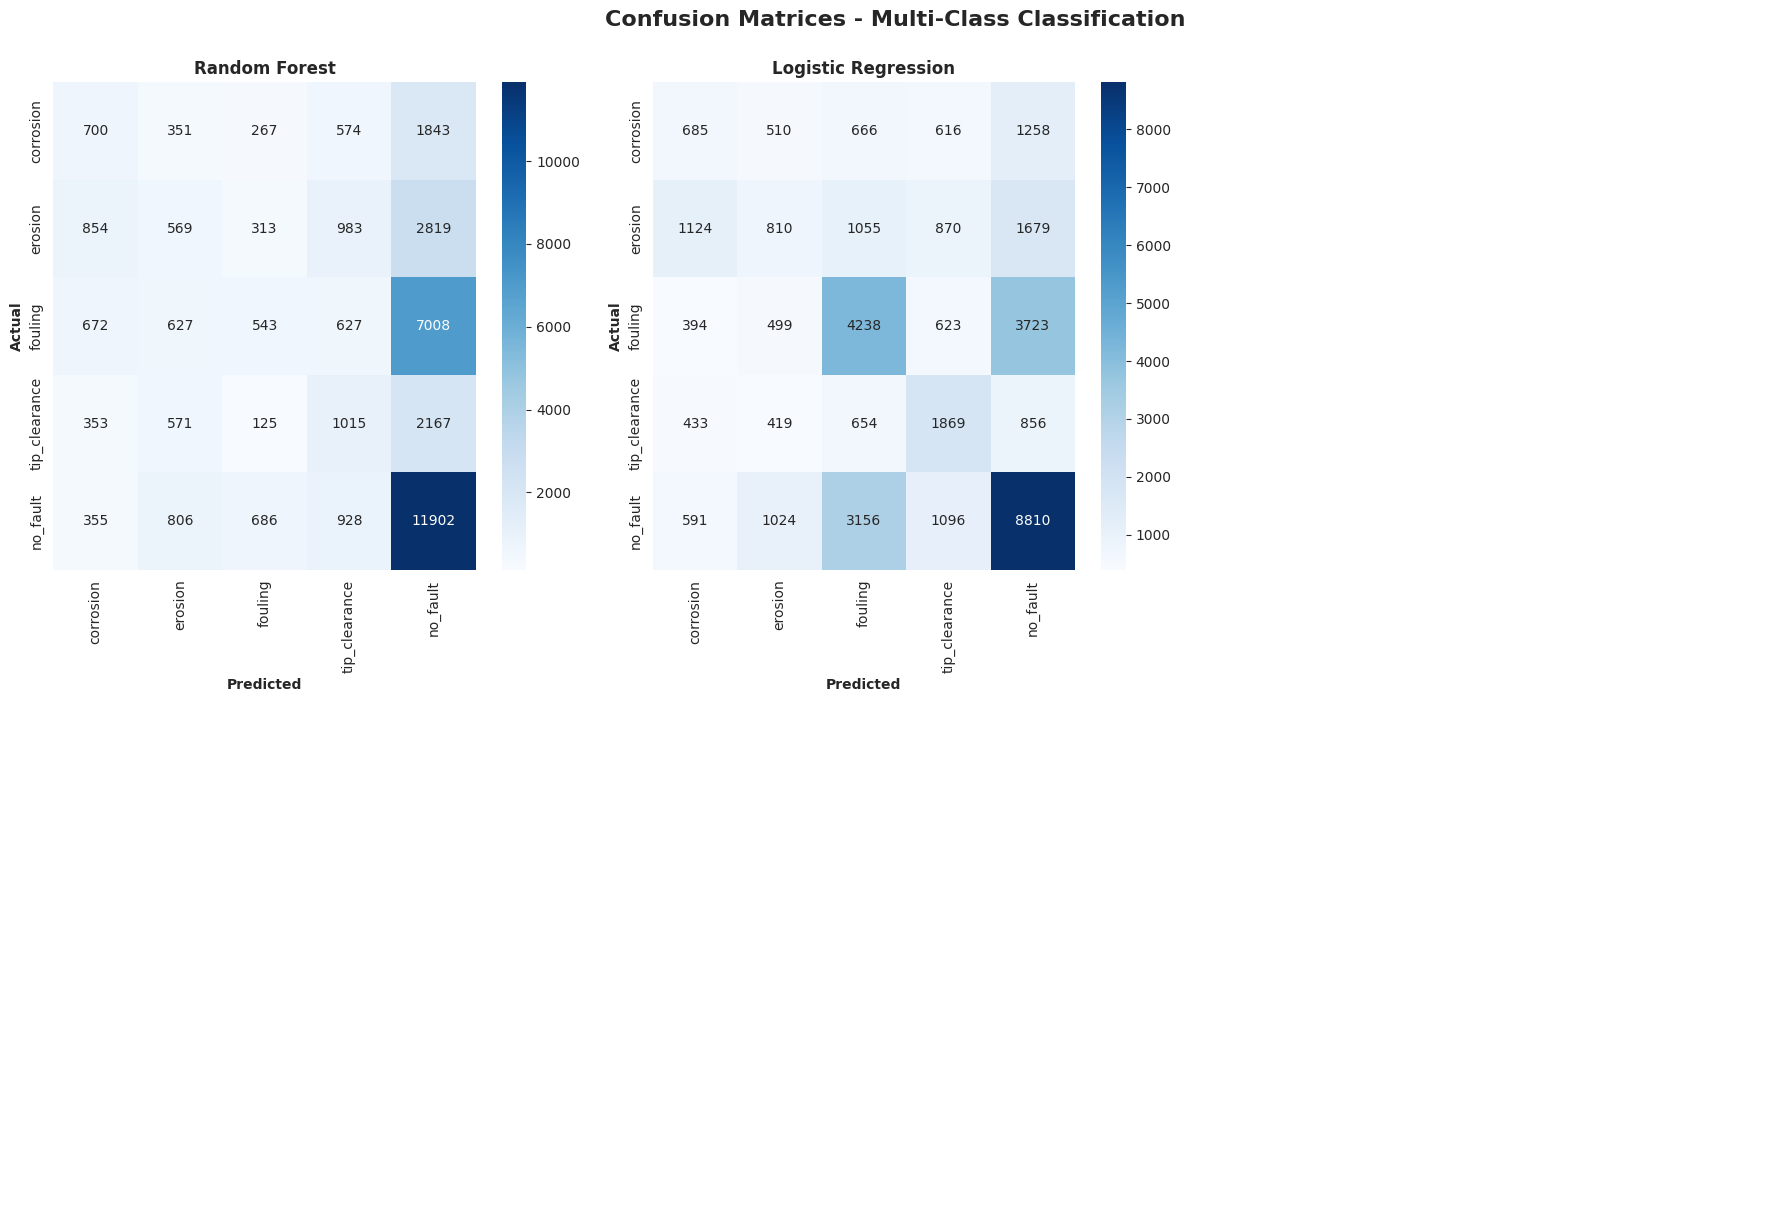

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, model_name in enumerate(models.keys()):
    if results[model_name] is not None and idx < len(axes):
        y_pred = results[model_name]['y_pred']
        cm = confusion_matrix(y_test, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=label_names,
                   yticklabels=label_names)
        axes[idx].set_title(f'{model_name}', fontweight='bold', fontsize=12)
        axes[idx].set_xlabel('Predicted', fontweight='bold')
        axes[idx].set_ylabel('Actual', fontweight='bold')

# Hide unused subplots
for idx in range(len(models), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Confusion Matrices - Multi-Class Classification', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrices.png'), dpi=150, bbox_inches='tight')
plt.show()

## 10. Feature Importance

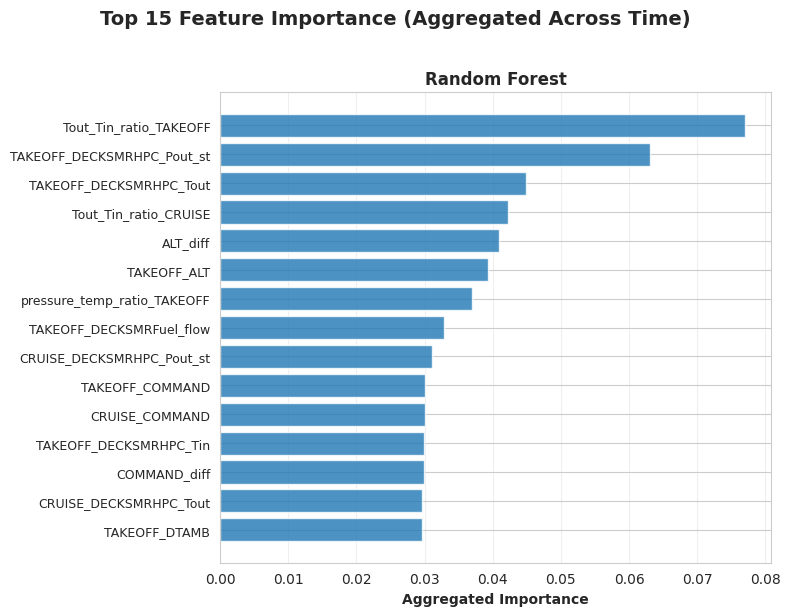

In [17]:
# Models that support feature importance
importance_models = ['Random Forest', 'Gradient Boosting']
if XGBOOST_AVAILABLE:
    importance_models.append('XGBoost')

available_importance_models = [m for m in importance_models if m in trained_models]

if available_importance_models:
    fig, axes = plt.subplots(1, len(available_importance_models), figsize=(8*len(available_importance_models), 6))
    if len(available_importance_models) == 1:
        axes = [axes]
    
    # Get feature names (accounting for flattened windows)
    feature_names_flat = []
    for t in range(WINDOW_SIZE):
        for feat in ALL_FEATURES:
            feature_names_flat.append(f"t{t}_{feat}")
    
    for idx, model_name in enumerate(available_importance_models):
        model = trained_models[model_name]
        
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            
            # Aggregate importance by original feature (sum across time steps)
            feature_importance_dict = {}
            for i, feat_name in enumerate(feature_names_flat):
                # Extract base feature name (remove time prefix)
                base_feat = '_'.join(feat_name.split('_')[1:])
                if base_feat not in feature_importance_dict:
                    feature_importance_dict[base_feat] = 0
                feature_importance_dict[base_feat] += importances[i]
            
            # Sort and get top 15
            sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:15]
            features, values = zip(*sorted_features)
            
            axes[idx].barh(range(len(features)), values, alpha=0.8)
            axes[idx].set_yticks(range(len(features)))
            axes[idx].set_yticklabels(features, fontsize=9)
            axes[idx].set_xlabel('Aggregated Importance', fontweight='bold')
            axes[idx].set_title(f'{model_name}', fontweight='bold')
            axes[idx].invert_yaxis()
            axes[idx].grid(axis='x', alpha=0.3)
    
    plt.suptitle('Top 15 Feature Importance (Aggregated Across Time)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'), 
                dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No models with feature importance available")

## 11. Best Model Selection

In [18]:
print("\n" + "="*80)
print("BEST MODEL SELECTION (Based on F1-Score)")
print("="*80)

best_f1 = 0
best_model_name = None

for model_name in models.keys():
    if results[model_name] is not None:
        f1 = results[model_name]['f1']
        if f1 > best_f1:
            best_f1 = f1
            best_model_name = model_name

if best_model_name:
    print(f"\nBest Model: {best_model_name}")
    print(f"  F1-Score:  {results[best_model_name]['f1']:.4f}")
    print(f"  Accuracy:  {results[best_model_name]['accuracy']:.4f}")
    print(f"  Precision: {results[best_model_name]['precision']:.4f}")
    print(f"  Recall:    {results[best_model_name]['recall']:.4f}")
    if results[best_model_name]['roc_auc']:
        print(f"  ROC AUC:   {results[best_model_name]['roc_auc']:.4f}")

print("\n" + "="*80)


BEST MODEL SELECTION (Based on F1-Score)

Best Model: Logistic Regression
  F1-Score:  0.3583
  Accuracy:  0.4358
  Precision: 0.3605
  Recall:    0.3638
  ROC AUC:   0.6899



## 12. Save Models and Artifacts

In [19]:
import pickle

print("\nSaving models and artifacts...")

# Save scaler
with open(os.path.join(OUTPUT_DIR, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)
print(f"Saved: scaler.pkl")

# Save feature names
with open(os.path.join(OUTPUT_DIR, 'feature_names.pkl'), 'wb') as f:
    pickle.dump(ALL_FEATURES, f)
print(f"Saved: feature_names.pkl")

# Save label mapping
with open(os.path.join(OUTPUT_DIR, 'label_names.pkl'), 'wb') as f:
    pickle.dump(label_names, f)
print(f"Saved: label_names.pkl")

# Save window parameters
window_params = {
    'window_size': WINDOW_SIZE,
    'step': STEP
}
with open(os.path.join(OUTPUT_DIR, 'window_params.pkl'), 'wb') as f:
    pickle.dump(window_params, f)
print(f"Saved: window_params.pkl")

# Save all trained models
for model_name, model in trained_models.items():
    filename = f'model_{model_name.replace(" ", "_").lower()}.pkl'
    with open(os.path.join(OUTPUT_DIR, filename), 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved: {filename}")

# Save best model separately
if best_model_name:
    best_model = trained_models[best_model_name]
    with open(os.path.join(OUTPUT_DIR, 'best_model.pkl'), 'wb') as f:
        pickle.dump(best_model, f)
    print(f"Saved: best_model.pkl ({best_model_name})")

print(f"\nAll artifacts saved to: {OUTPUT_DIR}")


Saving models and artifacts...
Saved: scaler.pkl
Saved: feature_names.pkl
Saved: label_names.pkl
Saved: window_params.pkl
Saved: model_random_forest.pkl
Saved: model_logistic_regression.pkl
Saved: best_model.pkl (Logistic Regression)

All artifacts saved to: ../results/traditional_ml


## 13. Summary Report

In [20]:
# Create summary report
report = []
report.append("="*80)
report.append("TRADITIONAL ML MULTI-CLASS CLASSIFICATION - SUMMARY REPORT")
report.append("="*80)
report.append(f"\nDataset:")
report.append(f"  Total cycles: {len(df_clean):,}")
report.append(f"  Total engines: {len(train_engines) + len(val_engines) + len(test_engines)}")
report.append(f"  Train engines: {len(train_engines)}")
report.append(f"  Val engines: {len(val_engines)}")
report.append(f"  Test engines: {len(test_engines)}")

report.append(f"\nWindowing:")
report.append(f"  Window size: {WINDOW_SIZE} time steps")
report.append(f"  Step size: {STEP}")
report.append(f"  Train windows: {len(X_train):,}")
report.append(f"  Val windows: {len(X_val):,}")
report.append(f"  Test windows: {len(X_test):,}")

report.append(f"\nFeatures: {len(ALL_FEATURES)}")
report.append(f"  - Original: {len(available_features)}")
report.append(f"  - Engineered: {len(engineered_features)}")
report.append(f"  - Per window: {len(ALL_FEATURES) * WINDOW_SIZE} (flattened)")

report.append(f"\nLabels: {label_names}")

report.append(f"\nModels Trained: {list(models.keys())}")

report.append(f"\nModel Performance (on test set):")
for model_name in models.keys():
    if results[model_name] is not None:
        report.append(f"  {model_name}:")
        report.append(f"    F1-Score:  {results[model_name]['f1']:.4f}")
        report.append(f"    Accuracy:  {results[model_name]['accuracy']:.4f}")
        report.append(f"    Precision: {results[model_name]['precision']:.4f}")
        report.append(f"    Recall:    {results[model_name]['recall']:.4f}")

if best_model_name:
    report.append(f"\nBest Model: {best_model_name} (F1={results[best_model_name]['f1']:.4f})")

report.append("\n" + "="*80)

# Print report
report_text = "\n".join(report)
print(report_text)

# Save report
with open(os.path.join(OUTPUT_DIR, 'summary_report.txt'), 'w') as f:
    f.write(report_text)

print(f"\nReport saved to: {os.path.join(OUTPUT_DIR, 'summary_report.txt')}")

TRADITIONAL ML MULTI-CLASS CLASSIFICATION - SUMMARY REPORT

Dataset:
  Total cycles: 249,000
  Total engines: 249
  Train engines: 173
  Val engines: 38
  Test engines: 38

Windowing:
  Window size: 10 time steps
  Step size: 1
  Train windows: 171,443
  Val windows: 37,658
  Test windows: 37,658

Features: 30
  - Original: 20
  - Engineered: 10
  - Per window: 300 (flattened)

Labels: ['corrosion', 'erosion', 'fouling', 'tip_clearance', 'no_fault']

Models Trained: ['Random Forest', 'Logistic Regression']

Model Performance (on test set):
  Random Forest:
    F1-Score:  0.2543
    Accuracy:  0.3911
    Precision: 0.2845
    Recall:    0.2797
  Logistic Regression:
    F1-Score:  0.3583
    Accuracy:  0.4358
    Precision: 0.3605
    Recall:    0.3638

Best Model: Logistic Regression (F1=0.3583)


Report saved to: ../results/traditional_ml/summary_report.txt
